In [19]:
import geopandas as gpd
import pandas as pd
import fiona
import matplotlib.pyplot as plt
from shapely.geometry import Point
from tqdm import tqdm
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.plot import show
import rasterio
import numpy as np
import yaml
import os
import seaborn as sns



# Load configuration
with open('../../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

def resolve_path(relative_path):
    return os.path.join(config['base_path'], relative_path)



##### Find the weighted average distance to nearest dam for all cropland

In [ ]:
# Load the dams data and convert to GeoDataFrame
africa_dams = pd.read_csv(resolve_path(config['Africa_Dam_csv_path']))
geometry = [Point(xy) for xy in zip(africa_dams['Long__res_'], africa_dams['Lat__res_'])]
gdf_dams = gpd.GeoDataFrame(africa_dams, geometry=geometry)
gdf_dams = gdf_dams.set_crs("EPSG:3857")  # Ensure the initial CRS is correct


# Load arid cropland tif
arid_cropland_tif_path = resolve_path(config['Arid_Cropland_tif_path'])
with rasterio.open(arid_cropland_tif_path) as src:
    cropland_data = src.read(1)
    cropland_transform = src.transform
    cropland_crs = src.crs

    # Reproject cropland data to EPSG:3857
    target_crs = 'EPSG:3857'
    if cropland_crs != target_crs:
        dst_transform, width, height = calculate_default_transform(
            cropland_crs, target_crs, src.width, src.height, *src.bounds)
        destination = np.empty((height, width), dtype=cropland_data.dtype)
        reproject(
            source = cropland_data,
            destination = destination,
            src_transform = cropland_transform,
            src_crs=cropland_crs,
            dst_transform = dst_transform,
            dst_crs=target_crs,
            resampling = Resampling.nearest
        )
        cropland_data = destination
        cropland_transform = dst_transform
        cropland_crs = target_crs

print(cropland_crs)

# Function to find distance to nearest dam
def nearest_dam_distance(point, dams):
    distances = dams.distance(point)
    return distances.min()

# Initialize variables for weighted average
weighted_distance_sum = 0
weight_sum = 0

# Extract the coordinates and values of cropland pixels
rows, cols = np.nonzero(cropland_data > 0)
cropland_values = cropland_data[rows, cols]

# Convert pixel coordinates to geographical coords
coordinates = [Point(cropland_transform * (col,row)) for row, col in zip(rows, cols)]

# Calulate distances and accumulate weighted sums
distances = []
for i, (point, value) in tqdm(enumerate(zip(coordinates, cropland_values)), total = len(coordinates)):
    distance = nearest_dam_distance(point, gdf_dams)
    distances.append(distance)
    weighted_distance_sum += distance * value
    weight_sum += value

# Calculate weighted average distance
if weight_sum > 0:
    weighted_avg_distance = weighted_distance_sum / weight_sum
    print(f"Weighted Average Distance to Nearest Dam: {weighted_avg_distance / 1000} kilometers")
else:
    print("No valid cropland pixels found.")

# Close
src.close()

##### Compute the average distance from CPIS to the nearest dam

In [47]:
# Load the dams data and convert to GeoDataFrame
africa_dams = pd.read_csv(resolve_path(config['Africa_Dam_csv_path']))
geometry = [Point(xy) for xy in zip(africa_dams['Long__res_'], africa_dams['Lat__res_'])]
gdf_dams = gpd.GeoDataFrame(africa_dams, geometry=geometry)

gdf_dams.plot()
plt.show()

# Load the CPIS shapefile
gdf_cpis = gpd.read_file(resolve_path(config['Combined_CPIS_shp_path']))

# Ensure both GeoDataFrames use the same CRS (unit in meters instead of degrees)
gdf_dams = gdf_dams.set_crs("EPSG:3857")
gdf_cpis = gdf_cpis.to_crs("EPSG:3857")

# Calculate distances from each CPIS to the nearest dam
gdf_cpis['nearest_dam_distance'] = gdf_cpis.geometry.apply(lambda x: gdf_dams.distance(x).min())

# Calculate average distance from CPIS to nearest dam
average_distance_cpis = (gdf_cpis['nearest_dam_distance']).mean()
print(f"Average Distance to Nearest Dam (CPIS): {average_distance_cpis / 1000} kilometers")


AttributeError: 'DataFrame' object has no attribute 'crs'

In [ ]:
# Calculate the targeting ratio
targeting_ratio = weighted_avg_distance / average_distance_cpis
print(f"Targeting Ratio: {targeting_ratio}")

Binned Targeting Ratio Values

In [ ]:
# Define the distance thresholds in meters (since EPSG:3857 uses meters)
thresholds = [1.5e6, 2.5e6, 3.5e6, 4.5e6, 5.5e6]

# Calculate distances from cropland pixels to the nearest dam
cropland_distances = []
for point, value in zip(coordinates, cropland_values):
    distance = nearest_dam_distance(point, gdf_dams)
    cropland_distances.append(distance)

# Calculate the percentage of distances below each threshold for cropland

# Create a dataframe from the cropland distances and values
cropland_df = pd.DataFrame({
    'distance': cropland_distances,
    'value': cropland_values
})

# Loop through each threshold and calculate the percentages for cropland
for threshold in thresholds:
    cropland_below_threshold = cropland_df[cropland_df['distance'] < threshold]
    percent_below_threshold_cropland = (len(cropland_below_threshold) / len(cropland_df)) * 100
    print(f"Percentage of cropland distances below {threshold / 1000} kilometers: {percent_below_threshold_cropland:.2f}%")

# Calculate distances from each CPIS to the nearest dam
gdf_cpis['nearest_dam_distance'] = gdf_cpis.geometry.apply(lambda x: nearest_dam_distance(x, gdf_dams))

# Loop through each threshold and calculate the percentages for CPIS
for threshold in thresholds:
    cpis_below_threshold = gdf_cpis[gdf_cpis['nearest_dam_distance'] < threshold]
    percent_below_threshold_cpis = (len(cpis_below_threshold) / len(gdf_cpis)) * 100
    print(f"Percentage of CPIS distances below {threshold / 1000} meters: {percent_below_threshold_cpis:.2f}%")


##### Consider Distribution of Distance Data

In [ ]:

# Calculate distances and accumulate weighted sums for cropland
cropland_distances = []
for i, (point, value) in tqdm(enumerate(zip(coordinates, cropland_values)), total=len(coordinates)):
    distance = nearest_dam_distance(point, gdf_dams)
    if value > 0:  # Ensure that we only include cropland pixels that are effectively cropland
        cropland_distances.append(distance)

# Plotting
plt.figure(figsize=(12, 6))

# Plot histogram of CPIS distances
sns.histplot(gdf_cpis['nearest_dam_distance'], color="red", label='CPIS Distances', kde=True, stat="density", bins=30)

# Plot histogram of Cropland distances
sns.histplot(cropland_distances, color="blue", label='Cropland Distances', kde=True, stat="density", bins=30)

plt.title('Distribution of Distances to Nearest Dams')
plt.xlabel('Distance to Nearest Dam (meters)')
plt.ylabel('Density')
plt.legend()
plt.show()


Distribution with weighted distance values, probably not valid:

In [2]:
# Calculate distances and accumulate weighted sums for cropland
cropland_weighted_distances = []
for i, (point, value) in tqdm(enumerate(zip(coordinates, cropland_values)), total=len(coordinates)):
    distance = nearest_dam_distance(point, gdf_dams)
    if value > 0:  # Ensure that we only include cropland pixels that are effectively cropland
        cropland_weighted_distances.append(distance * value)

# Plotting
plt.figure(figsize=(12, 6))

# Plot histogram of CPIS distances
sns.histplot(gdf_cpis['nearest_dam_distance'], color="red", label='CPIS Distances', kde=True, stat="density", bins=30)

# Plot histogram of Cropland distances
sns.histplot(cropland_weighted_distances, color="blue", label='Cropland Distances', kde=True, stat="density", bins=30)

plt.title('Distribution of Distances to Nearest Dams')
plt.xlabel('Distance to Nearest Dam (meters)')
plt.ylabel('Density')
plt.legend()
plt.show()


NameError: name 'tqdm' is not defined

#### Using Elevation Data
##### First make sure the coordinate systems are the same
Reproject the Raster Data to EPSG:3857

In [26]:
# Load the dams data and convert to GeoDataFrame
africa_dams = pd.read_csv(resolve_path(config['Africa_Dam_csv_path']))
geometry = [Point(xy) for xy in zip(africa_dams['Long__res_'], africa_dams['Lat__res_'])]
gdf_dams = gpd.GeoDataFrame(africa_dams, geometry=geometry)
gdf_dams = gdf_dams.set_crs("EPSG:3857")  # Ensure the initial CRS is correct

gdf_cpis = gpd.read_file(resolve_path(config['Combined_CPIS_shp_path']))

# Reproject to EPSG:3857
gdf_dams = gdf_dams.to_crs("EPSG:3857")
gdf_cpis = gdf_cpis.to_crs("EPSG:3857")

# Path to the .adf file
elevation_path = resolve_path(config['Africa_Elevation_rast_path'])

# Open the .adf file using rasterio
with rasterio.open(elevation_path) as src:
    # Identify the CRS of the DEM
    dem_crs = src.crs
    transform = src.transform
    elevation_data = src.read(1)  # Read the first band
    gradient_y, gradient_x = np.gradient(elevation_data, src.res[1], src.res[0])

# Open the .adf file using rasterio and reproject to EPSG:3857 if needed
with rasterio.open(elevation_path) as src:
    dem_crs = src.crs
    if dem_crs != "EPSG:3857":
        transform, width, height = calculate_default_transform(
            src.crs, "EPSG:3857", src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': "EPSG:3857",
            'transform': transform,
            'width': width,
            'height': height,
            'driver': 'GTiff'  # Ensure a compatible driver
        })

        with rasterio.open('dem_3857.tif', 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs="EPSG:3857",
                    resampling=Resampling.nearest)


# Read the reprojected DEM
with rasterio.open('dem_3857.tif') as src:
    transform = src.transform
    elevation_data = src.read(1)  # Read the first band
    gradient_y, gradient_x = np.gradient(elevation_data, src.res[1], src.res[0])

# Calculate the gradients in x and y directions
gradient_y, gradient_x = np.gradient(elevation_data, src.res[1], src.res[0])

# Function to calculate gradient direction at a specific point
def get_gradient_direction(lon, lat, transform, gradient_x, gradient_y):
    # Convert geographic coordinates to raster coordinates
    col, row = ~transform * (lon, lat)
    col, row = int(col), int(row)
    # Get the gradient values at the point
    grad_x = gradient_x[row, col]
    grad_y = gradient_y[row, col]
    # Calculate the gradient direction
    direction = np.arctan2(grad_y, grad_x)
    return direction

# Calculate gradient directions at dam locations
gdf_dams['gradient_direction'] = gdf_dams.apply(lambda row: get_gradient_direction(row.geometry.x, row.geometry.y, transform, gradient_x, gradient_y), axis=1)

# Function to determine if a CPIS location is upstream or downstream relative to the nearest dam
def classify_cpis_location(cpis_point, dams_gdf):
    # Find the nearest dam
    nearest_dam = dams_gdf.geometry.distance(cpis_point).idxmin()
    nearest_dam_direction = dams_gdf.loc[nearest_dam, 'gradient_direction']
    cpis_lon, cpis_lat = cpis_point.x, cpis_point.y
    # Calculate the direction from the CPIS to the dam
    col, row = ~transform * (cpis_lon, cpis_lat)
    col, row = int(col), int(row)
    grad_x = gradient_x[row, col]
    grad_y = gradient_y[row, col]
    cpis_direction = np.arctan2(grad_y, grad_x)
    # Classify as upstream or downstream
    if np.cos(nearest_dam_direction - cpis_direction) > 0:
        return 'downstream'
    else:
        return 'upstream'

# Calculate centroids of CPIS polygons
gdf_cpis['centroid'] = gdf_cpis.geometry.centroid

# Classify each CPIS location using its centroid
gdf_cpis['position_relative_to_dam'] = gdf_cpis['centroid'].apply(lambda x: classify_cpis_location(x, gdf_dams))

# Drop the centroid column before saving
gdf_cpis_cleaned = gdf_cpis.drop(columns=['centroid'])

# Ensure the correct geometry column is used
gdf_cpis.set_geometry('geometry', inplace=True)

# Print the columns and data types to ensure there is only one geometry column
print(gdf_cpis_cleaned.dtypes)

# Print the first few rows to check the structure of the GeoDataFrame
print(gdf_cpis_cleaned.head())

# Save the updated GeoDataFrames if necessary
gdf_dams.to_file(resolve_path(config['Dams_with_Gradients_gpkg_path']), driver='GPKG')
gdf_cpis_cleaned.to_file(resolve_path(config['CPIS_Classified_gpkg_path']), driver='GPKG')

print(gdf_cpis[['geometry', 'position_relative_to_dam']].head())

ID                             int64
year_2000                      int64
year_2021                      int64
Country                       object
Country Co                    object
geometry                    geometry
position_relative_to_dam      object
dtype: object
   ID  year_2000  year_2021       Country Country Co  \
0   1          1          1  South Africa        ZAF   
1   2          1          1  South Africa        ZAF   
2   3          1          1  South Africa        ZAF   
3   4          1          1  South Africa        ZAF   
4   5          1          1  South Africa        ZAF   

                                            geometry position_relative_to_dam  
0  POLYGON ((2158598.021 -4057555.506, 2158658.42...                 upstream  
1  POLYGON ((2158740.433 -4056950.848, 2158788.75...                 upstream  
2  POLYGON ((2286656.768 -4053677.724, 2286693.00...                 upstream  
3  POLYGON ((2285644.300 -4053175.531, 2285704.69...               dow

In [27]:

# Count the number of CPIS locations upstream and downstream
upstream_count = gdf_cpis_cleaned[gdf_cpis_cleaned['position_relative_to_dam'] == 'upstream'].shape[0]
downstream_count = gdf_cpis_cleaned[gdf_cpis_cleaned['position_relative_to_dam'] == 'downstream'].shape[0]

print(f"Number of CPIS locations upstream of the nearest dam: {upstream_count}")
print(f"Number of CPIS locations downstream of the nearest dam: {downstream_count}")

# Optionally, use distance bins to analyze the distribution
thresholds = [1.5e6, 2.5e6, 3.5e6, 4.5e6, 5.5e6]
gdf_cpis_cleaned['nearest_dam_distance'] = gdf_cpis_cleaned.geometry.apply(lambda x: gdf_dams.geometry.distance(x).min())

for threshold in thresholds:
    upstream_within_threshold = gdf_cpis_cleaned[(gdf_cpis_cleaned['position_relative_to_dam'] == 'upstream') & (gdf_cpis_cleaned['nearest_dam_distance'] < threshold)]
    downstream_within_threshold = gdf_cpis_cleaned[(gdf_cpis_cleaned['position_relative_to_dam'] == 'downstream') & (gdf_cpis_cleaned['nearest_dam_distance'] < threshold)]
    
    percent_upstream = (len(upstream_within_threshold) / len(gdf_cpis_cleaned[gdf_cpis_cleaned['nearest_dam_distance'] < threshold])) * 100
    percent_downstream = (len(downstream_within_threshold) / len(gdf_cpis_cleaned[gdf_cpis_cleaned['nearest_dam_distance'] < threshold])) * 100
    
    print(f"Percentage of CPIS locations upstream of the nearest dam within {threshold / 1000:.1f} kilometers: {percent_upstream:.2f}%")
    print(f"Percentage of CPIS locations downstream of the nearest dam within {threshold / 1000:.1f} kilometers: {percent_downstream:.2f}%")



Number of CPIS locations upstream of the nearest dam: 14102
Number of CPIS locations downstream of the nearest dam: 18262
Percentage of CPIS locations upstream of the nearest dam within 1500.0 kilometers: 71.05%
Percentage of CPIS locations downstream of the nearest dam within 1500.0 kilometers: 28.95%
Percentage of CPIS locations upstream of the nearest dam within 2500.0 kilometers: 45.14%
Percentage of CPIS locations downstream of the nearest dam within 2500.0 kilometers: 54.86%
Percentage of CPIS locations upstream of the nearest dam within 3500.0 kilometers: 39.24%
Percentage of CPIS locations downstream of the nearest dam within 3500.0 kilometers: 60.76%
Percentage of CPIS locations upstream of the nearest dam within 4500.0 kilometers: 41.65%
Percentage of CPIS locations downstream of the nearest dam within 4500.0 kilometers: 58.35%
Percentage of CPIS locations upstream of the nearest dam within 5500.0 kilometers: 43.57%
Percentage of CPIS locations downstream of the nearest dam w

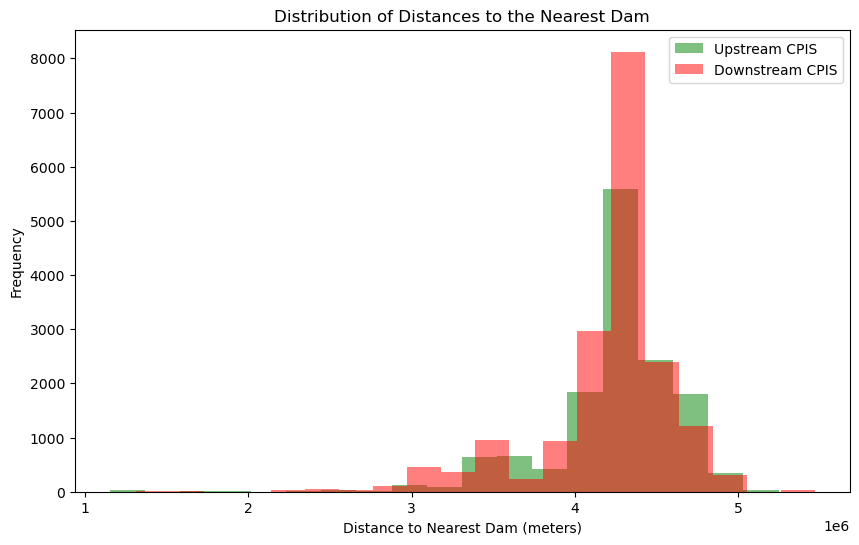

In [28]:
# Plot histograms of distances to the nearest dam
fig, ax = plt.subplots(figsize=(10, 6))

# Histogram for upstream CPIS locations
gdf_cpis_cleaned[gdf_cpis_cleaned['position_relative_to_dam'] == 'upstream']['nearest_dam_distance'].plot(
    kind='hist', bins=20, ax=ax, alpha=0.5, color='green', label='Upstream CPIS')

# Histogram for downstream CPIS locations
gdf_cpis_cleaned[gdf_cpis_cleaned['position_relative_to_dam'] == 'downstream']['nearest_dam_distance'].plot(
    kind='hist', bins=20, ax=ax, alpha=0.5, color='red', label='Downstream CPIS')

plt.legend()
plt.title('Distribution of Distances to the Nearest Dam')
plt.xlabel('Distance to Nearest Dam (meters)')
plt.ylabel('Frequency')

plt.show()


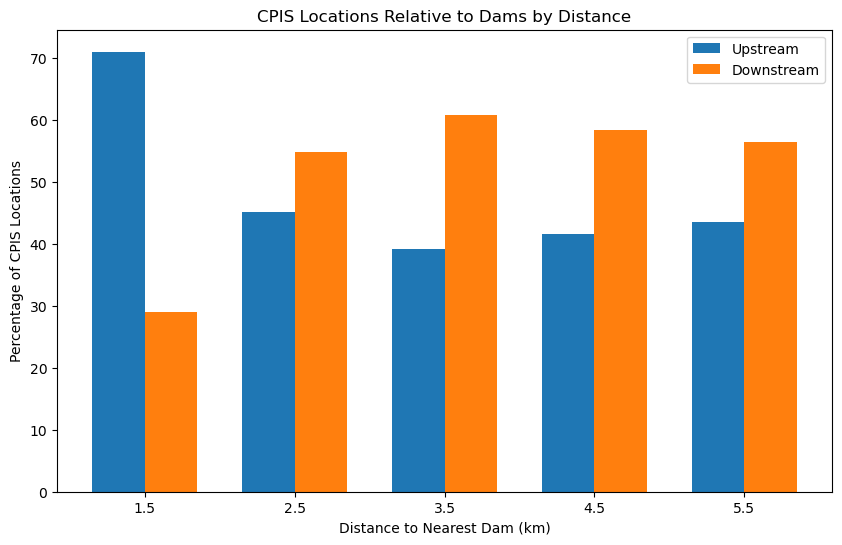

In [29]:
# Define the thresholds in kilometers for easier interpretation
thresholds_km = [1.5, 2.5, 3.5, 4.5, 5.5]
percent_upstream = []
percent_downstream = []

for threshold in thresholds:
    upstream_within_threshold = gdf_cpis_cleaned[
        (gdf_cpis_cleaned['position_relative_to_dam'] == 'upstream') & (gdf_cpis_cleaned['nearest_dam_distance'] < threshold)]
    downstream_within_threshold = gdf_cpis_cleaned[
        (gdf_cpis_cleaned['position_relative_to_dam'] == 'downstream') & (gdf_cpis_cleaned['nearest_dam_distance'] < threshold)]
    
    percent_upstream.append((len(upstream_within_threshold) / len(gdf_cpis_cleaned[gdf_cpis_cleaned['nearest_dam_distance'] < threshold])) * 100)
    percent_downstream.append((len(downstream_within_threshold) / len(gdf_cpis_cleaned[gdf_cpis_cleaned['nearest_dam_distance'] < threshold])) * 100)

# Bar chart for the comparison
fig, ax = plt.subplots(figsize=(10, 6))
index = np.arange(len(thresholds_km))
bar_width = 0.35

bars1 = ax.bar(index, percent_upstream, bar_width, label='Upstream')
bars2 = ax.bar(index + bar_width, percent_downstream, bar_width, label='Downstream')

ax.set_xlabel('Distance to Nearest Dam (km)')
ax.set_ylabel('Percentage of CPIS Locations')
ax.set_title('CPIS Locations Relative to Dams by Distance')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(thresholds_km)
ax.legend()

plt.show()
